In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display the first few rows of the train dataset
train_df.head()

,id,date_of_birth,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target
0,1,1993-03-14,1,0.036495,0.208897,2400,6,2,0,0,570,817,0
1,2,1966-09-27,1,0.023423,0.260438,2200,6,1,0,0,741,756,0
2,3,1931-01-11,2,0.027205,0.335922,3000,6,1,0,1,805,779,0
3,4,1953-01-07,1,0.009141,0.353779,2100,2,4,0,0,573,829,0
4,5,1943-11-17,0,0.068424,0.314966,2500,2,3,0,0,833,629,0


In [2]:
print(train_df.shape)
print(test_df.shape)

(20839, 13)
(1000, 12)


In [3]:
train_df.dtypes

id                            int64
date_of_birth                object
number_dependants             int64
credit_utilization          float64
debt_to_income_ratio        float64
monthly_income                int64
number_open_credit_lines      int64
number_open_loans             int64
number_90_days_past_due       int64
number_charged_off            int64
score1                        int64
score2                        int64
target                        int64
dtype: object

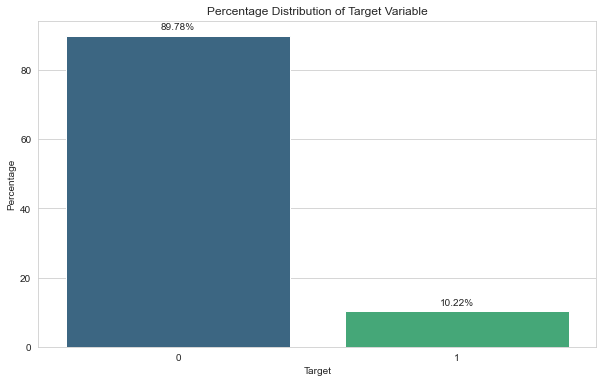

In [4]:
# Calculate the percentage distribution
target_counts = train_df['target'].value_counts(normalize=True) * 100
target_counts = target_counts.reset_index()
target_counts.columns = ['target', 'percentage']

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='target', y='percentage', data=target_counts, palette='viridis')

# Annotate with the percentage
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f') + '%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.title('Percentage Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Percentage')
plt.show()

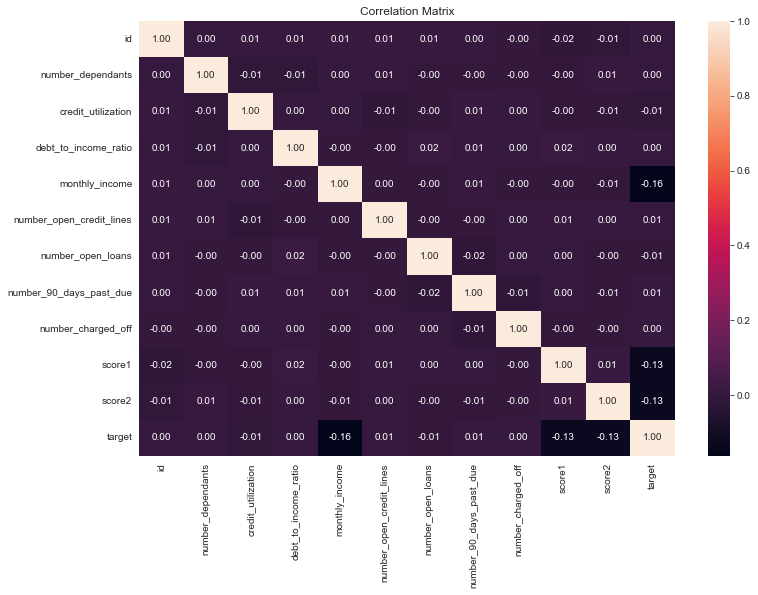

In [5]:
# Correlation matrix to understand the relationships between features
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

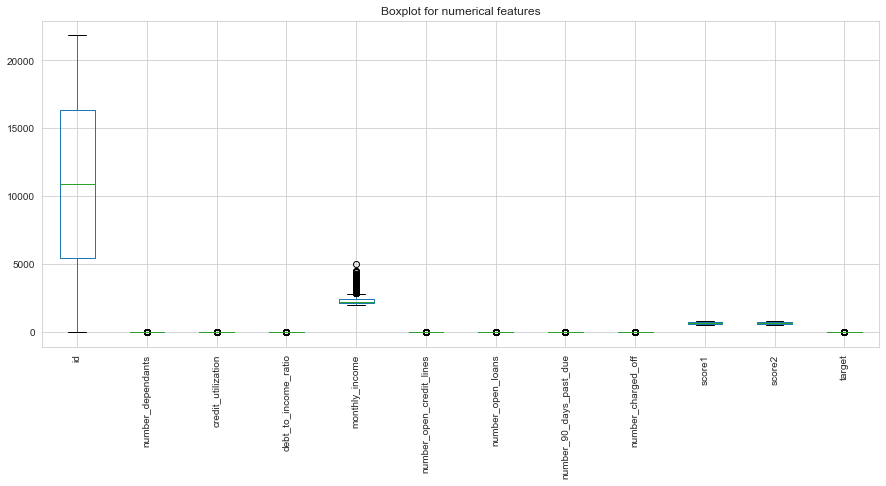

In [6]:
# We will also check for any potential outliers in the numerical features
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
train_df[numerical_features].boxplot(figsize=(15, 6))
plt.title('Boxplot for numerical features')
plt.xticks(rotation=90)
plt.show()

In [7]:
# Convert 'date_of_birth' to age
train_df['age'] = (pd.to_datetime('today').normalize() - pd.to_datetime(train_df['date_of_birth'])).dt.days // 365
test_df['age'] = (pd.to_datetime('today').normalize() - pd.to_datetime(test_df['date_of_birth'])).dt.days // 365
train_df.drop('date_of_birth', axis=1, inplace=True)
test_df.drop('date_of_birth', axis=1, inplace=True)

In [8]:
train_df

,id,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target,age
0,1,1,0.036495,0.208897,2400,6,2,0,0,570,817,0,30
1,2,1,0.023423,0.260438,2200,6,1,0,0,741,756,0,57
2,3,2,0.027205,0.335922,3000,6,1,0,1,805,779,0,92
3,4,1,0.009141,0.353779,2100,2,4,0,0,573,829,0,70
4,5,0,0.068424,0.314966,2500,2,3,0,0,833,629,0,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20834,21835,0,0.003702,0.182518,2900,3,1,0,0,602,644,0,63
20835,21836,0,0.030451,0.390220,2700,4,2,0,0,779,641,0,47
20836,21837,2,0.014581,0.202639,2400,6,1,0,0,599,544,0,24
20837,21838,0,0.164027,0.348271,2300,4,1,1,0,578,680,0,59


In [9]:
# Check for missing values in the train data
missing_values_train = train_df.isnull().sum()
missing_values_train = missing_values_train[missing_values_train > 0]
print("Missing values in training data:", missing_values_train)

# Check for missing values in the test data
missing_values_test = test_df.isnull().sum()
missing_values_test = missing_values_test[missing_values_test > 0]
print("Missing values in test data:", missing_values_test)

Missing values in training data: Series([], dtype: int64)
Missing values in test data: Series([], dtype: int64)


In [10]:
#drop the id column 
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

In [11]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import accuracy_score

# Assuming 'target' is the name of your target variable
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

# Adding a constant to the model (necessary for statsmodels)
X_train = sm.add_constant(X_train)

# Building and fitting the model
model = sm.Logit(y_train, X_train)
result = model.fit()

# Printing the summary of the model
print(result.summary())

# Making predictions on the training set
train_predictions = result.predict(X_train)
train_predictions = (train_predictions > 0.5).astype(int)  # Converting probabilities to class labels (0 or 1)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))



Optimization terminated successfully.
         Current function value: 0.292094
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                20839
Model:                          Logit   Df Residuals:                    20827
Method:                           MLE   Df Model:                           11
Date:                Thu, 09 Nov 2023   Pseudo R-squ.:                  0.1144
Time:                        13:47:11   Log-Likelihood:                -6087.0
converged:                       True   LL-Null:                       -6873.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       10.9051      0.396     27.551      0.000      10.129

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# from sklearn.preprocessing import StandardScaler


# # Scaling the 'monthly_income' feature
# scaler = StandardScaler()
# train_df['monthly_income'] = scaler.fit_transform(train_df[['monthly_income']])
# test_df['monthly_income'] = scaler.transform(test_df[['monthly_income']])

# # Continue with the logistic regression as before
# X_train = train_df.drop('target', axis=1)
# y_train = train_df['target']

# X_train = sm.add_constant(X_train)

# # Rebuilding and fitting the model
# model = sm.Logit(y_train, X_train)
# result = model.fit()

# # Printing the summary of the model
# print(result.summary())

# # Making predictions on the training set
# train_predictions = result.predict(X_train)
# train_predictions = (train_predictions > 0.5).astype(int)  # Converting probabilities to class labels (0 or 1)

# # Evaluating the model
# print("Classification Report for Training Data:")
# print(classification_report(y_train, train_predictions))

# print("Confusion Matrix for Training Data:")
# print(confusion_matrix(y_train, train_predictions))

# print("Accuracy Score for Training Data:")
# print(accuracy_score(y_train, train_predictions))


In [13]:
from sklearn.ensemble import RandomForestClassifier

# # Scaling the 'monthly_income' feature
# scaler = StandardScaler()
# train_df['monthly_income'] = scaler.fit_transform(train_df[['monthly_income']])
# test_df['monthly_income'] = scaler.transform(test_df[['monthly_income']])

# Preparing the data for Random Forest
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

# Creating and fitting the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Making predictions on the training set
train_predictions = rf_model.predict(X_train)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18710
           1       1.00      1.00      1.00      2129

    accuracy                           1.00     20839
   macro avg       1.00      1.00      1.00     20839
weighted avg       1.00      1.00      1.00     20839

Confusion Matrix for Training Data:
[[18710     0]
 [    1  2128]]
Accuracy Score for Training Data:
0.9999520130524497


In [14]:
X_train

,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,age
0,1,0.036495,0.208897,2400,6,2,0,0,570,817,30
1,1,0.023423,0.260438,2200,6,1,0,0,741,756,57
2,2,0.027205,0.335922,3000,6,1,0,1,805,779,92
3,1,0.009141,0.353779,2100,2,4,0,0,573,829,70
4,0,0.068424,0.314966,2500,2,3,0,0,833,629,80
...,...,...,...,...,...,...,...,...,...,...,...
20834,0,0.003702,0.182518,2900,3,1,0,0,602,644,63
20835,0,0.030451,0.390220,2700,4,2,0,0,779,641,47
20836,2,0.014581,0.202639,2400,6,1,0,0,599,544,24
20837,0,0.164027,0.348271,2300,4,1,1,0,578,680,59


In [15]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# # Scaling the 'monthly_income' feature
# scaler = StandardScaler()
# train_df['monthly_income'] = scaler.fit_transform(train_df[['monthly_income']])
# test_df['monthly_income'] = scaler.transform(test_df[['monthly_income']])

# Preparing the data for XGBoost
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

# Creating and fitting the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Making predictions on the training set
train_predictions = xgb_model.predict(X_train)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     18710
           1       0.98      0.31      0.47      2129

    accuracy                           0.93     20839
   macro avg       0.96      0.66      0.72     20839
weighted avg       0.93      0.93      0.91     20839

Confusion Matrix for Training Data:
[[18699    11]
 [ 1465   664]]
Accuracy Score for Training Data:
0.9291712654158069


In [16]:
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming train_df and test_df are already defined and loaded

# # Scaling the 'monthly_income' feature
# scaler = StandardScaler()
# train_df['monthly_income'] = scaler.fit_transform(train_df[['monthly_income']])
# test_df['monthly_income'] = scaler.transform(test_df[['monthly_income']])

# Preparing the data for LightGBM
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

# Creating and fitting the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# Making predictions on the training set
train_predictions = lgb_model.predict(X_train)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))


[LightGBM] [Info] Number of positive: 2129, number of negative: 18710
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 20839, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102164 -> initscore=-2.173406
[LightGBM] [Info] Start training from score -2.173406
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     18710
           1       1.00      0.09      0.16      2129

    accuracy                           0.91     20839
   macro avg       0.95      0.54      0.55     20839
weighted avg       0.92      0.91      0.87     20839

Confusion Matrix for Training Data:
[[18710     0]
 [ 1945   184]]
Accuracy

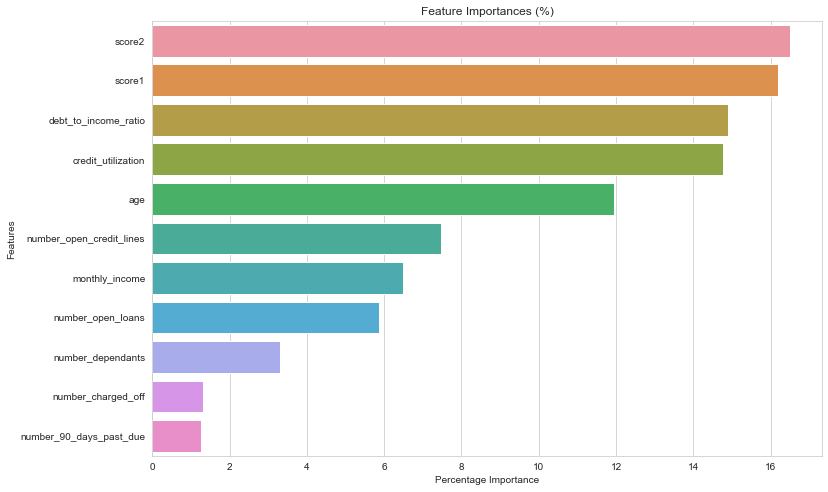

In [17]:
# Extracting feature importances
feature_importances = rf_model.feature_importances_
features = X_train.columns

# Creating a DataFrame to hold feature names and their importance scores
importances_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})

# Sorting the DataFrame by importance score
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Converting importances to percentages
importances_df['Importance'] = importances_df['Importance'] * 100

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Features', data=importances_df)
plt.title('Feature Importances (%)')
plt.xlabel('Percentage Importance')
plt.ylabel('Features')
plt.show()

In [18]:
# Feature Scaling
# Scale the features using StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_df.drop('target', axis=1))

# Convert the scaled arrays back to dataframes
train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_df.drop('target', axis=1).columns)

y_train = train_df['target']

# Train a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_clf.fit(train_data_scaled, y_train)


# Making predictions on the training set
train_predictions = rf_clf.predict(train_data_scaled)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18710
           1       1.00      1.00      1.00      2129

    accuracy                           1.00     20839
   macro avg       1.00      1.00      1.00     20839
weighted avg       1.00      1.00      1.00     20839

Confusion Matrix for Training Data:
[[18710     0]
 [    1  2128]]
Accuracy Score for Training Data:
0.9999520130524497


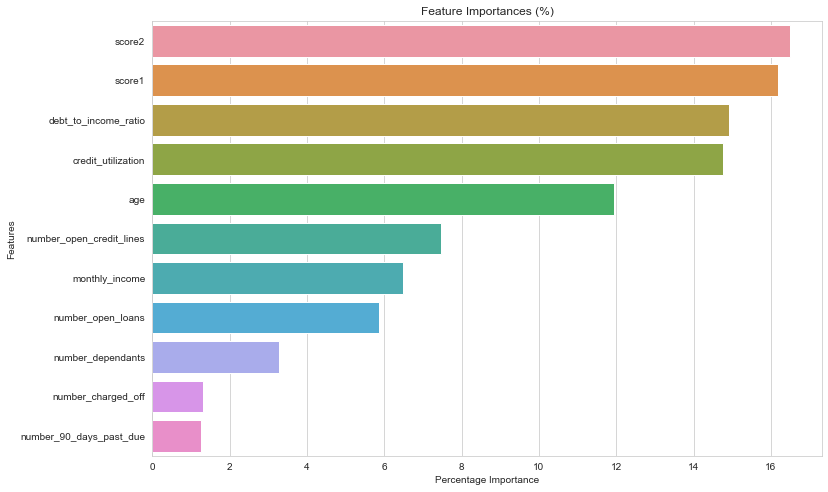

In [19]:
# Extracting feature importances
feature_importances = rf_clf.feature_importances_
features = train_data_scaled.columns

# Creating a DataFrame to hold feature names and their importance scores
importances_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})

# Sorting the DataFrame by importance score
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Converting importances to percentages
importances_df['Importance'] = importances_df['Importance'] * 100

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Features', data=importances_df)
plt.title('Feature Importances (%)')
plt.xlabel('Percentage Importance')
plt.ylabel('Features')
plt.show()

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18710
           1       1.00      1.00      1.00      2129

    accuracy                           1.00     20839
   macro avg       1.00      1.00      1.00     20839
weighted avg       1.00      1.00      1.00     20839

Confusion Matrix for Training Data:
[[18710     0]
 [    1  2128]]
Accuracy Score for Training Data:
0.9999520130524497


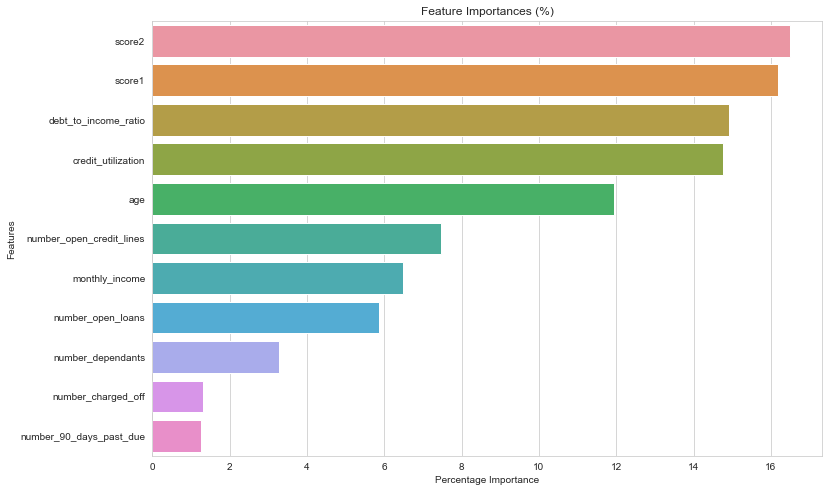

In [20]:
# Scale the features using MaxAbsScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_df is already defined and loaded

scaler = MaxAbsScaler()
train_data_scaled = scaler.fit_transform(train_df.drop('target', axis=1))

# Convert the scaled arrays back to dataframes
train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_df.drop('target', axis=1).columns)

y_train = train_df['target']

# Initialize and fit the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(train_data_scaled, y_train)

# Making predictions on the training set
train_predictions = rf_clf.predict(train_data_scaled)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))

# Extracting feature importances
feature_importances = rf_clf.feature_importances_
features = train_data_scaled.columns

# Creating a DataFrame to hold feature names and their importance scores
importances_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})

# Sorting the DataFrame by importance score and converting to percentages
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df['Importance'] = importances_df['Importance'] * 100

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Features', data=importances_df)
plt.title('Feature Importances (%)')
plt.xlabel('Percentage Importance')
plt.ylabel('Features')
plt.show()

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18710
           1       1.00      1.00      1.00      2129

    accuracy                           1.00     20839
   macro avg       1.00      1.00      1.00     20839
weighted avg       1.00      1.00      1.00     20839

Confusion Matrix for Training Data:
[[18710     0]
 [    1  2128]]
Accuracy Score for Training Data:
0.9999520130524497


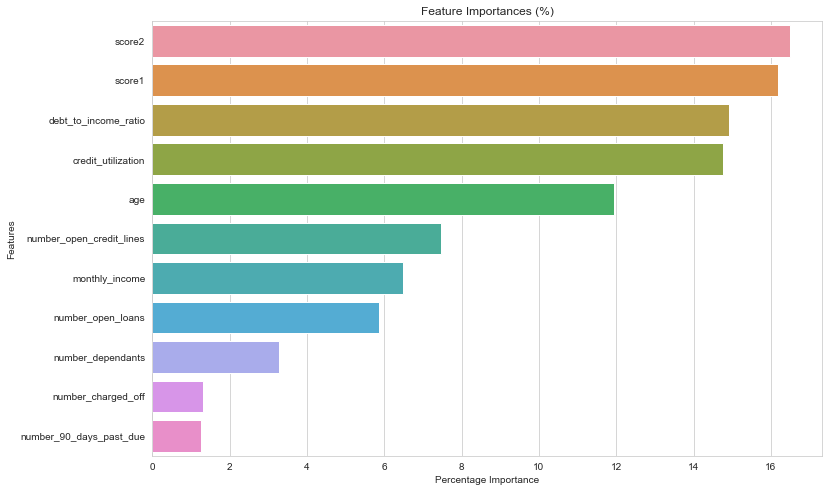

In [21]:
# Feature Scaling
# Scale the features using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_df is already defined and loaded

scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_df.drop('target', axis=1))

# Convert the scaled arrays back to dataframes
train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_df.drop('target', axis=1).columns)

y_train = train_df['target']

# Initialize and fit the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(train_data_scaled, y_train)

# Making predictions on the training set
train_predictions = rf_clf.predict(train_data_scaled)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))

# Extracting feature importances
feature_importances = rf_clf.feature_importances_
features = train_data_scaled.columns

# Creating a DataFrame to hold feature names and their importance scores
importances_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})

# Sorting the DataFrame by importance score and converting to percentages
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df['Importance'] = importances_df['Importance'] * 100

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Features', data=importances_df)
plt.title('Feature Importances (%)')
plt.xlabel('Percentage Importance')
plt.ylabel('Features')
plt.show()


Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18710
           1       1.00      1.00      1.00      2129

    accuracy                           1.00     20839
   macro avg       1.00      1.00      1.00     20839
weighted avg       1.00      1.00      1.00     20839

Confusion Matrix for Training Data:
[[18710     0]
 [    1  2128]]
Accuracy Score for Training Data:
0.9999520130524497


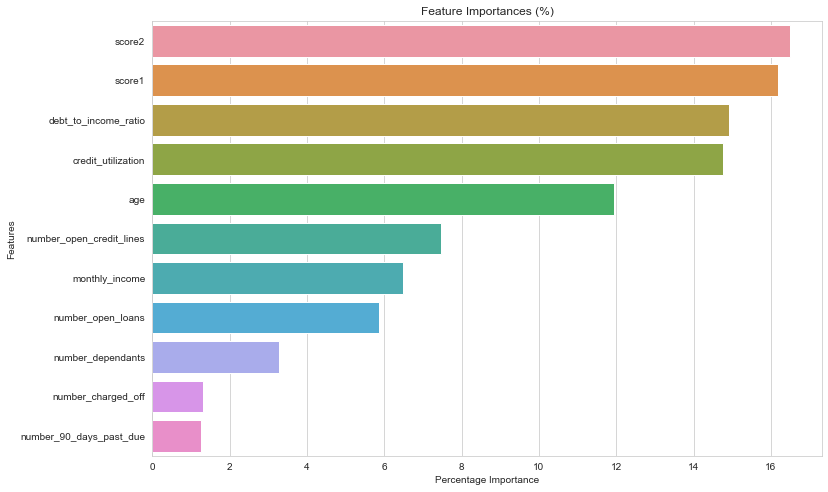

In [22]:
# Feature Scaling
# Scale the features using RobustScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_df is already defined and loaded

scaler = RobustScaler()
train_data_scaled = scaler.fit_transform(train_df.drop('target', axis=1))

# Convert the scaled arrays back to dataframes
train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_df.drop('target', axis=1).columns)

y_train = train_df['target']

# Initialize and fit the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(train_data_scaled, y_train)

# Making predictions on the training set
train_predictions = rf_clf.predict(train_data_scaled)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))

# Extracting feature importances
feature_importances = rf_clf.feature_importances_
features = train_data_scaled.columns

# Creating a DataFrame to hold feature names and their importance scores
importances_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})

# Sorting the DataFrame by importance score and converting to percentages
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df['Importance'] = importances_df['Importance'] * 100

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Features', data=importances_df)
plt.title('Feature Importances (%)')
plt.xlabel('Percentage Importance')
plt.ylabel('Features')
plt.show()

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18710
           1       1.00      1.00      1.00      2129

    accuracy                           1.00     20839
   macro avg       1.00      1.00      1.00     20839
weighted avg       1.00      1.00      1.00     20839

Confusion Matrix for Training Data:
[[18710     0]
 [    1  2128]]
Accuracy Score for Training Data:
0.9999520130524497


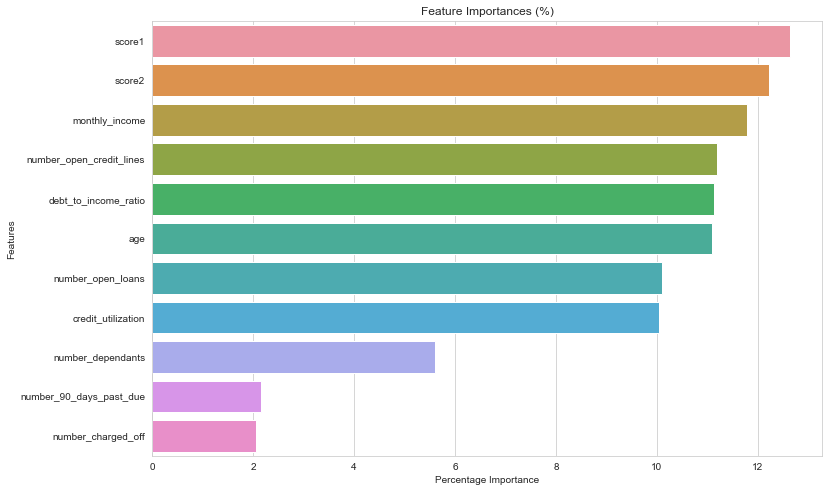

In [23]:
# Feature Scaling
# Scale the features using Normalizer
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_df is already defined and loaded

scaler = Normalizer()
train_data_scaled = scaler.fit_transform(train_df.drop('target', axis=1))

# Convert the scaled arrays back to dataframes
train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_df.drop('target', axis=1).columns)

y_train = train_df['target']

# Initialize and fit the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(train_data_scaled, y_train)

# Making predictions on the training set
train_predictions = rf_clf.predict(train_data_scaled)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))

# Extracting feature importances
feature_importances = rf_clf.feature_importances_
features = train_data_scaled.columns

# Creating a DataFrame to hold feature names and their importance scores
importances_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})

# Sorting the DataFrame by importance score and converting to percentages
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df['Importance'] = importances_df['Importance'] * 100

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Features', data=importances_df)
plt.title('Feature Importances (%)')
plt.xlabel('Percentage Importance')
plt.ylabel('Features')
plt.show()


In [24]:
train_df

,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target,age
0,1,0.036495,0.208897,2400,6,2,0,0,570,817,0,30
1,1,0.023423,0.260438,2200,6,1,0,0,741,756,0,57
2,2,0.027205,0.335922,3000,6,1,0,1,805,779,0,92
3,1,0.009141,0.353779,2100,2,4,0,0,573,829,0,70
4,0,0.068424,0.314966,2500,2,3,0,0,833,629,0,80
...,...,...,...,...,...,...,...,...,...,...,...,...
20834,0,0.003702,0.182518,2900,3,1,0,0,602,644,0,63
20835,0,0.030451,0.390220,2700,4,2,0,0,779,641,0,47
20836,2,0.014581,0.202639,2400,6,1,0,0,599,544,0,24
20837,0,0.164027,0.348271,2300,4,1,1,0,578,680,0,59


In [25]:
train_data_scaled

,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,age
0,0.000385,0.000014,0.000080,0.923533,0.002309,0.000770,0.000000,0.000000,0.219339,0.314386,0.011544
1,0.000409,0.000010,0.000107,0.900860,0.002457,0.000409,0.000000,0.000000,0.303426,0.309568,0.023340
2,0.000624,0.000008,0.000105,0.936432,0.001873,0.000312,0.000000,0.000312,0.251276,0.243160,0.028717
3,0.000429,0.000004,0.000152,0.901156,0.000858,0.001716,0.000000,0.000000,0.245887,0.355742,0.030039
4,0.000000,0.000025,0.000116,0.922393,0.000738,0.001107,0.000000,0.000000,0.307342,0.232074,0.029517
...,...,...,...,...,...,...,...,...,...,...,...
20834,0.000000,0.000001,0.000060,0.956563,0.000990,0.000330,0.000000,0.000000,0.198569,0.212423,0.020781
20835,0.000000,0.000011,0.000135,0.936622,0.001388,0.000694,0.000000,0.000000,0.270233,0.222361,0.016304
20836,0.000790,0.000006,0.000080,0.947547,0.002369,0.000395,0.000000,0.000000,0.236492,0.214777,0.009475
20837,0.000000,0.000066,0.000141,0.932008,0.001621,0.000405,0.000405,0.000000,0.234218,0.275550,0.023908


In [26]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler, Normalizer
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming train_df and test_df are already defined and loaded

# Scaling all features using StandardScaler
# scaler = StandardScaler()
# scaler = MaxAbsScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()
scaler = Normalizer()

X_train = scaler.fit_transform(train_df.drop('target', axis=1))
y_train = train_df['target']

# Creating and fitting the LightGBM model
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

# Making predictions on the training set
train_predictions = lgb_model.predict(X_train)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))


[LightGBM] [Info] Number of positive: 2129, number of negative: 18710
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 20839, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.102164 -> initscore=-2.173406
[LightGBM] [Info] Start training from score -2.173406
Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     18710
           1       1.00      0.10      0.19      2129

    accuracy                           0.91     20839
   macro avg       0.95      0.55      0.57     20839
weighted avg       0.92      0.91      0.87     20839

Confusion Matrix for Training Data:
[[18710     0]
 [ 1906   223]]
Accuracy

In [37]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Assuming train_df is already defined and loaded

# Separating the features and the target variable
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

# Scaling all features using StandardScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Convert the scaled array back to a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Adding a constant to the model (necessary for statsmodels)
X_train_scaled = sm.add_constant(X_train_scaled)

# Building and fitting the model
model = sm.Logit(y_train, X_train_scaled)
result = model.fit()

# Printing the summary of the model
print(result.summary())

# Making predictions on the training set
train_predictions = result.predict(X_train_scaled)
train_predictions = (train_predictions > 0.5).astype(int)  # Converting probabilities to class labels (0 or 1)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))


Optimization terminated successfully.
         Current function value: 0.292094
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                20839
Model:                          Logit   Df Residuals:                    20827
Method:                           MLE   Df Model:                           11
Date:                Thu, 09 Nov 2023   Pseudo R-squ.:                  0.1144
Time:                        13:38:13   Log-Likelihood:                -6087.0
converged:                       True   LL-Null:                       -6873.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.1349      0.127     -1.066      0.287      -0.383

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Classification Report:
Class 0: {'precision': 0.9981293425975414, 'recall': 0.8982683982683982, 'f1-score': 0.9455696202531645, 'support': 20790}
Class 1: {'precision': 0.006575857209957727, 'recall': 0.2857142857142857, 'f1-score': 0.012855831037649219, 'support': 49}

Average Confusion Matrix:
[[3.735e+03 7.000e+00]
 [4.230e+02 2.800e+00]]

Average Accuracy:
0.8968280963626556


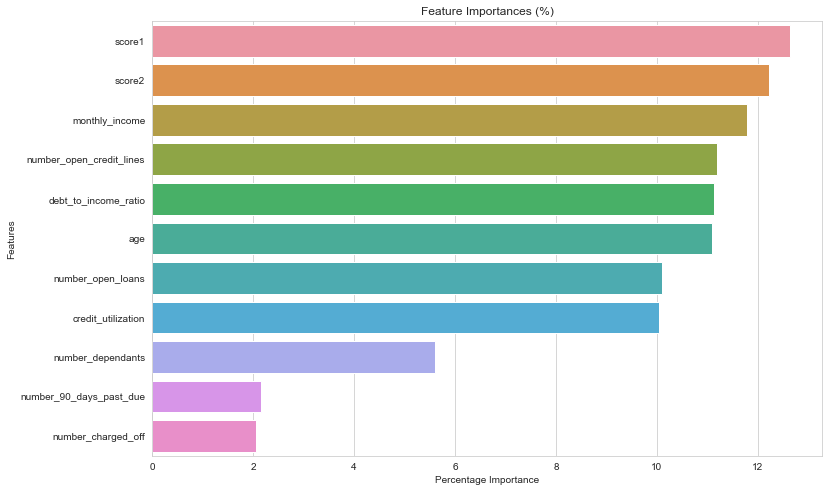

In [25]:
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_df is already defined and loaded

scaler = Normalizer()
train_data_scaled = scaler.fit_transform(train_df.drop('target', axis=1))
train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_df.drop('target', axis=1).columns)
y_train = train_df['target']

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Lists to store metrics for each fold
confusion_matrices = []
accuracies = []
true_positives = {0: 0, 1: 0}
false_positives = {0: 0, 1: 0}
false_negatives = {0: 0, 1: 0}
true_negatives = {0: 0, 1: 0}

for train_index, test_index in skf.split(train_data_scaled, y_train):
    X_train_fold, X_test_fold = train_data_scaled.iloc[train_index], train_data_scaled.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model on this fold
    rf_clf.fit(X_train_fold, y_train_fold)

    # Make predictions on the test set for this fold
    y_pred_fold = rf_clf.predict(X_test_fold)

    # Compute confusion matrix and add to totals
    cm = confusion_matrix(y_test_fold, y_pred_fold)
    confusion_matrices.append(cm)
    tp, fp, fn, tn = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    true_positives[0] += tp
    false_positives[0] += fp
    false_negatives[0] += fn
    true_negatives[0] += tn
    true_positives[1] += tn
    false_positives[1] += fn
    false_negatives[1] += fp
    true_negatives[1] += tp

    # Add accuracy
    accuracies.append(accuracy_score(y_test_fold, y_pred_fold))

# Calculate average metrics
average_confusion_matrix = np.mean(confusion_matrices, axis=0)
average_accuracy = np.mean(accuracies)

# Calculate average classification report
avg_classification_report = {}
for class_id in [0, 1]:
    precision = true_positives[class_id] / (true_positives[class_id] + false_positives[class_id])
    recall = true_positives[class_id] / (true_positives[class_id] + false_negatives[class_id])
    f1 = 2 * (precision * recall) / (precision + recall)
    support = true_positives[class_id] + false_negatives[class_id]
    avg_classification_report[class_id] = {'precision': precision, 'recall': recall, 'f1-score': f1, 'support': support}

# Print the average metrics
print("Average Classification Report:")
for class_id, metrics in avg_classification_report.items():
    print(f"Class {class_id}: {metrics}")

print("\nAverage Confusion Matrix:")
print(average_confusion_matrix)
print("\nAverage Accuracy:")
print(average_accuracy)

# Plot feature importances
rf_clf.fit(train_data_scaled, y_train)  # Fit on entire dataset for feature importance
feature_importances = rf_clf.feature_importances_
features = train_data_scaled.columns
importances_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
importances_df['Importance'] = importances_df['Importance'] * 100
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Features', data=importances_df)
plt.title('Feature Importances (%)')
plt.xlabel('Percentage Importance')
plt.ylabel('Features')
plt.show()
